In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
import torch 
import torch.nn as nn

from models.resnet.resnet18 import ResNet18
from datasets.cifar100_dataset import CIFAR100Dataset
from utils.dataset_utils import train_test_split, get_transformation
from utils.cifar100_utils import CIFAR100_LABELS, get_superclass, CIFAR100_DECODING

from models.moe_layer.resnet18.resnet18_moe import ResNet18MoE
from models.moe_layer.soft_gating_networks import SimpleGate
from models.moe_layer.resnet.moe_block_layer import ResidualMoeBlockLayer, MoeBlockLayer
from models.moe_layer.resnet18.resnet18_experts import NarrowResNet18Expert
from torchvision import transforms

import wandb

In [2]:
def build_model(moe_variant, constraint, num_experts, pos, run_path, filename):
    in_channels = [64, 64, 128, 256]

    if moe_variant == 'Residual':
        moe_layer = ResidualMoeBlockLayer
    elif moe_variant == 'Default':
        moe_layer = MoeBlockLayer
    else:
        raise ValueError('Invalid model')

    if constraint == 'importance':
        gate = SimpleGate(
            in_channels=in_channels[pos-1],
            num_experts=num_experts,
            top_k=2,
            use_noise=True,
            name='SimpleGate',
            loss_fkt='importance',
            w_aux_loss=0.5
        )
    elif constraint == 'kl':
        gate = SimpleGate(
            in_channels=in_channels[pos-1],
            num_experts=num_experts,
            top_k=2,
            use_noise=True,
            name='SimpleGate',
            loss_fkt='kl_divergence',
            w_aux_loss=0.5
        )

    elif constraint == 'relative':
        gate = RelativeImportanceGate(
            in_channels=in_channels[pos-1],
            num_experts=num_experts,
            top_k=2,
            use_noise=True,
            name='relative Importance',
            constr_threshold=0.5
        )

    elif constraint == 'mean':
        gate = AbsoluteImportanceGate(
            in_channels=in_channels[pos-1],
            num_experts=num_experts,
            top_k=2,
            use_noise=True,
            name='mean Importance',
            constr_threshold=0.3
        )

    else:
        raise ValueError('Invalid Constraint')

    moe_block = moe_layer(
        num_experts=num_experts,
        layer_position=pos,
        top_k=2,
        gating_network=gate,
        resnet_expert=NarrowResNet18Expert)

    name = str(moe_variant) + '_' + str(constraint) + '_' + str(num_experts)

    model = ResNet18MoE(
        moe_layers=[moe_block],
        name=name
    )

    # Load model weights
    file_model = wandb.restore(
        filename, run_path=run_path, root='./model_weights')

    # # Load parameters
    model.load_state_dict(torch.load(file_model.name)['model_state_dict'])

    # # Move model to cuda
    model.to(model.device)

    print('Load model: ' + filename)

    return model, moe_block

In [3]:
class WeightHook:
    def __init__(self, module, num_experts):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.weights = []
        self.weights_sparsely = []
        self.selected_experts = []
        self.selected_experts_combinations = []
        self.num_experts = num_experts

    def hook_fn(self, module, input, output):
        for pred in output:
            self.weights.append(nn.functional.softmax(pred, dim=0).cpu().tolist())
            top_k_logits, top_k_indices = pred.topk(2)
            top_k_weights = nn.functional.softmax(top_k_logits, dim=0)
            weights = np.zeros(self.num_experts)
            weights[top_k_indices[0]] = top_k_weights[0].cpu()
            weights[top_k_indices[1]] = top_k_weights[1].cpu()
            self.weights_sparsely.append(weights.tolist())
            experts = [top_k_indices[0].cpu().item(),
                       top_k_indices[1].cpu().item()]
            self.selected_experts = self.selected_experts + experts
            self.selected_experts_combinations.append(set(experts))

    def close(self):
        self.hook.remove()

In [4]:
def compute_number_of_pair_activations(model, moe_block):
    handle = WeightHook(moe_block.gate.fc, moe_block.num_experts)
    model.eval()
    transformations_test = get_transformation('cifar100', phase='test')
    test_data = CIFAR100Dataset(root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test)
    eval_results = model.evaluate(test_data)['acc']
    handle.close()
    selected_experts_combinations = handle.selected_experts_combinations
    c = Counter(str(s) for s in selected_experts_combinations)
    print('Accuracy: ', eval_results)
    return c

In [5]:
def create_heatmap(expert_combinations, filename):
    data = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for i in range(3):
        for j in range(1, 4):
            data[j-1][i] = expert_combinations['{' + '{}, {}'.format(i, j) + '}']
    print(data)
    mask = np.array([[False, True, True], [False, False, True],[False, False, False]])
    x_axis_labels = [1, 2, 3]
    y_axis_labels = [2, 3, 4]
    sns.set(rc={'figure.figsize':(5,5)})

    sns.set_style("white")
    ax = sns.heatmap(data, annot=True, cbar=False, fmt="d", mask=mask, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel('Expert A', fontsize = 15) 
    plt.ylabel('Expert B', fontsize = 15) 
    ax.figure.savefig('activations_importance_4_4.png', format='png', dpi=1000) 

In [6]:
model, moe_layer = build_model(moe_variant='Residual', constraint='importance', num_experts=4, pos=1, run_path='lukas-struppek/final_resnet_18/16aj0dnf', filename='Residual_4_topK=2_loss=importance_w_aux=0.5_moePosition=1_1_final.tar')

Load model: Residual_4_topK=2_loss=importance_w_aux=0.5_moePosition=1_1_final.tar


In [7]:
c = compute_number_of_pair_activations(model, moe_layer)

------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  Residual_importance_4
Evaluation on 10,000 samples
Evaluation complete in  00:00:08
Evaluation Accuracy: 0.7280
------------------------------------ Finished Evaluation ------------------------------------

Accuracy:  0.728


In [8]:
c

Counter({'{0, 1}': 2805,
         '{2, 3}': 4761,
         '{0, 2}': 1350,
         '{0, 3}': 504,
         '{1, 3}': 338,
         '{1, 2}': 242})

[[2805, 0, 0], [1350, 242, 0], [504, 338, 4761]]


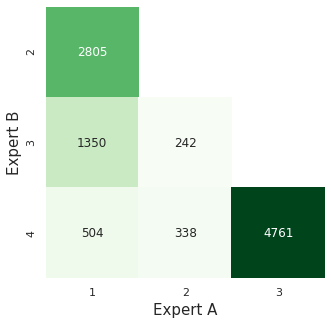

In [58]:
create_heatmap(c, 'importance-1-4.png')

In [21]:
# Importance 4 - 4
data2 =  [[1919, 1919, 1571], [1215, 2217, 522], [1571, 522, 2556]]
mask = np.array([[False, True, True], [False, False, True],[False, False, False]])
x_axis_labels = [1, 2, 3]
y_axis_labels = [2, 3, 4]

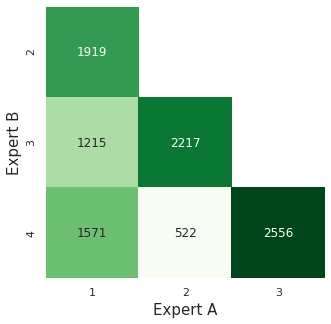

In [22]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("white")
ax = sns.heatmap(data2, annot=True, cbar=False, fmt="d", mask=mask, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Expert A', fontsize = 15) 
plt.ylabel('Expert B', fontsize = 15) 
ax.figure.savefig('activations_importance_4_4.png', format='png', dpi=1000) 

In [16]:
# Relative 1 - 4
data2 =  [[784, 1983, 959], [1840, 302, 2443], [987, 121, 5966]]
mask = np.array([[False, True, True], [False, False, True],[False, False, False]])
x_axis_labels = [1, 2, 3]
y_axis_labels = [2, 3, 4]

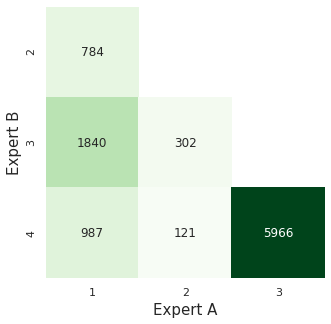

In [18]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("white")
ax = sns.heatmap(data2, annot=True, cbar=False, fmt="d", mask=mask, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Expert A', fontsize = 15) 
plt.ylabel('Expert B', fontsize = 15) 
ax.figure.savefig('activations_relative_1_4.png', format='png', dpi=1000) 

In [9]:
# Realtive 4 - 4
data2 =  [[1983, 1983, 959], [1378, 780, 2443], [959, 2443, 2457]]
mask = np.array([[False, True, True], [False, False, True],[False, False, False]])
x_axis_labels = [1, 2, 3]
y_axis_labels = [2, 3, 4]

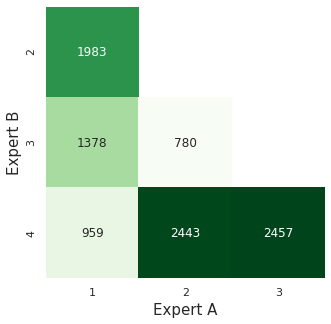

In [11]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("white")
ax = sns.heatmap(data2, annot=True, cbar=False, fmt="d", mask=mask, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Expert A', fontsize = 15) 
plt.ylabel('Expert B', fontsize = 15) 
ax.figure.savefig('activations_relative_4_4.png', format='png', dpi=1000) 

In [19]:
# Importance 1 - 4
data2 =  [[3616, 1983, 959], [943, 760, 2443], [242, 465, 1674]]
mask = np.array([[False, True, True], [False, False, True],[False, False, False]])
x_axis_labels = [1, 2, 3]
y_axis_labels = [2, 3, 4]

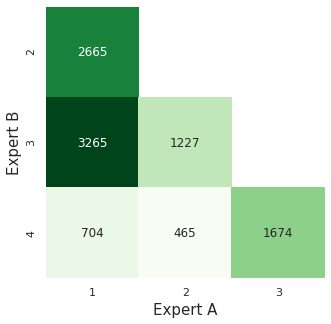

In [20]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("white")
ax = sns.heatmap(data2, annot=True, cbar=False, fmt="d", mask=mask, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Expert A', fontsize = 15) 
plt.ylabel('Expert B', fontsize = 15) 
ax.figure.savefig('activations_importance_1_4.png', format='png', dpi=1000) 